# 导入需要的库和数据

In [1]:
import numpy as np 
import pandas as pd 
import os 
os.chdir(os.path.abspath(os.curdir))
from tqdm import tqdm
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Common Model Helpers
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import time

from sklearn.model_selection import StratifiedKFold

from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

import featuretools as ft
from autogluon.tabular import TabularDataset, TabularPredictor

In [2]:
train = pd.read_excel('fintech训练营/train.xlsx')
test = pd.read_excel('fintech训练营/test_A榜.xlsx')

# 1.数据预处理

## 1.1 缺失值转换为np.nan

In [3]:
datasets = [train,test]

In [4]:
for dataset in datasets:
    for i in dataset.columns:
        dataset[i] = dataset[i].apply(lambda x : np.nan if x=='?' else x)

## 1.2 类别型数据特征编码

In [5]:
label = LabelEncoder()
for dataset in datasets:
    for i in dataset.columns:
        if dataset[i].dtype == 'object':
            if i != 'CUST_UID':
                dataset[i] = label.fit_transform(dataset[i])

# 2. 数据探索

## 2.1 判断是否数据增强

In [7]:
train['LABEL'].value_counts() # 3:1不需要数据增强

LABEL
0    30000
1    10000
Name: count, dtype: int64

## 2.2 异常值

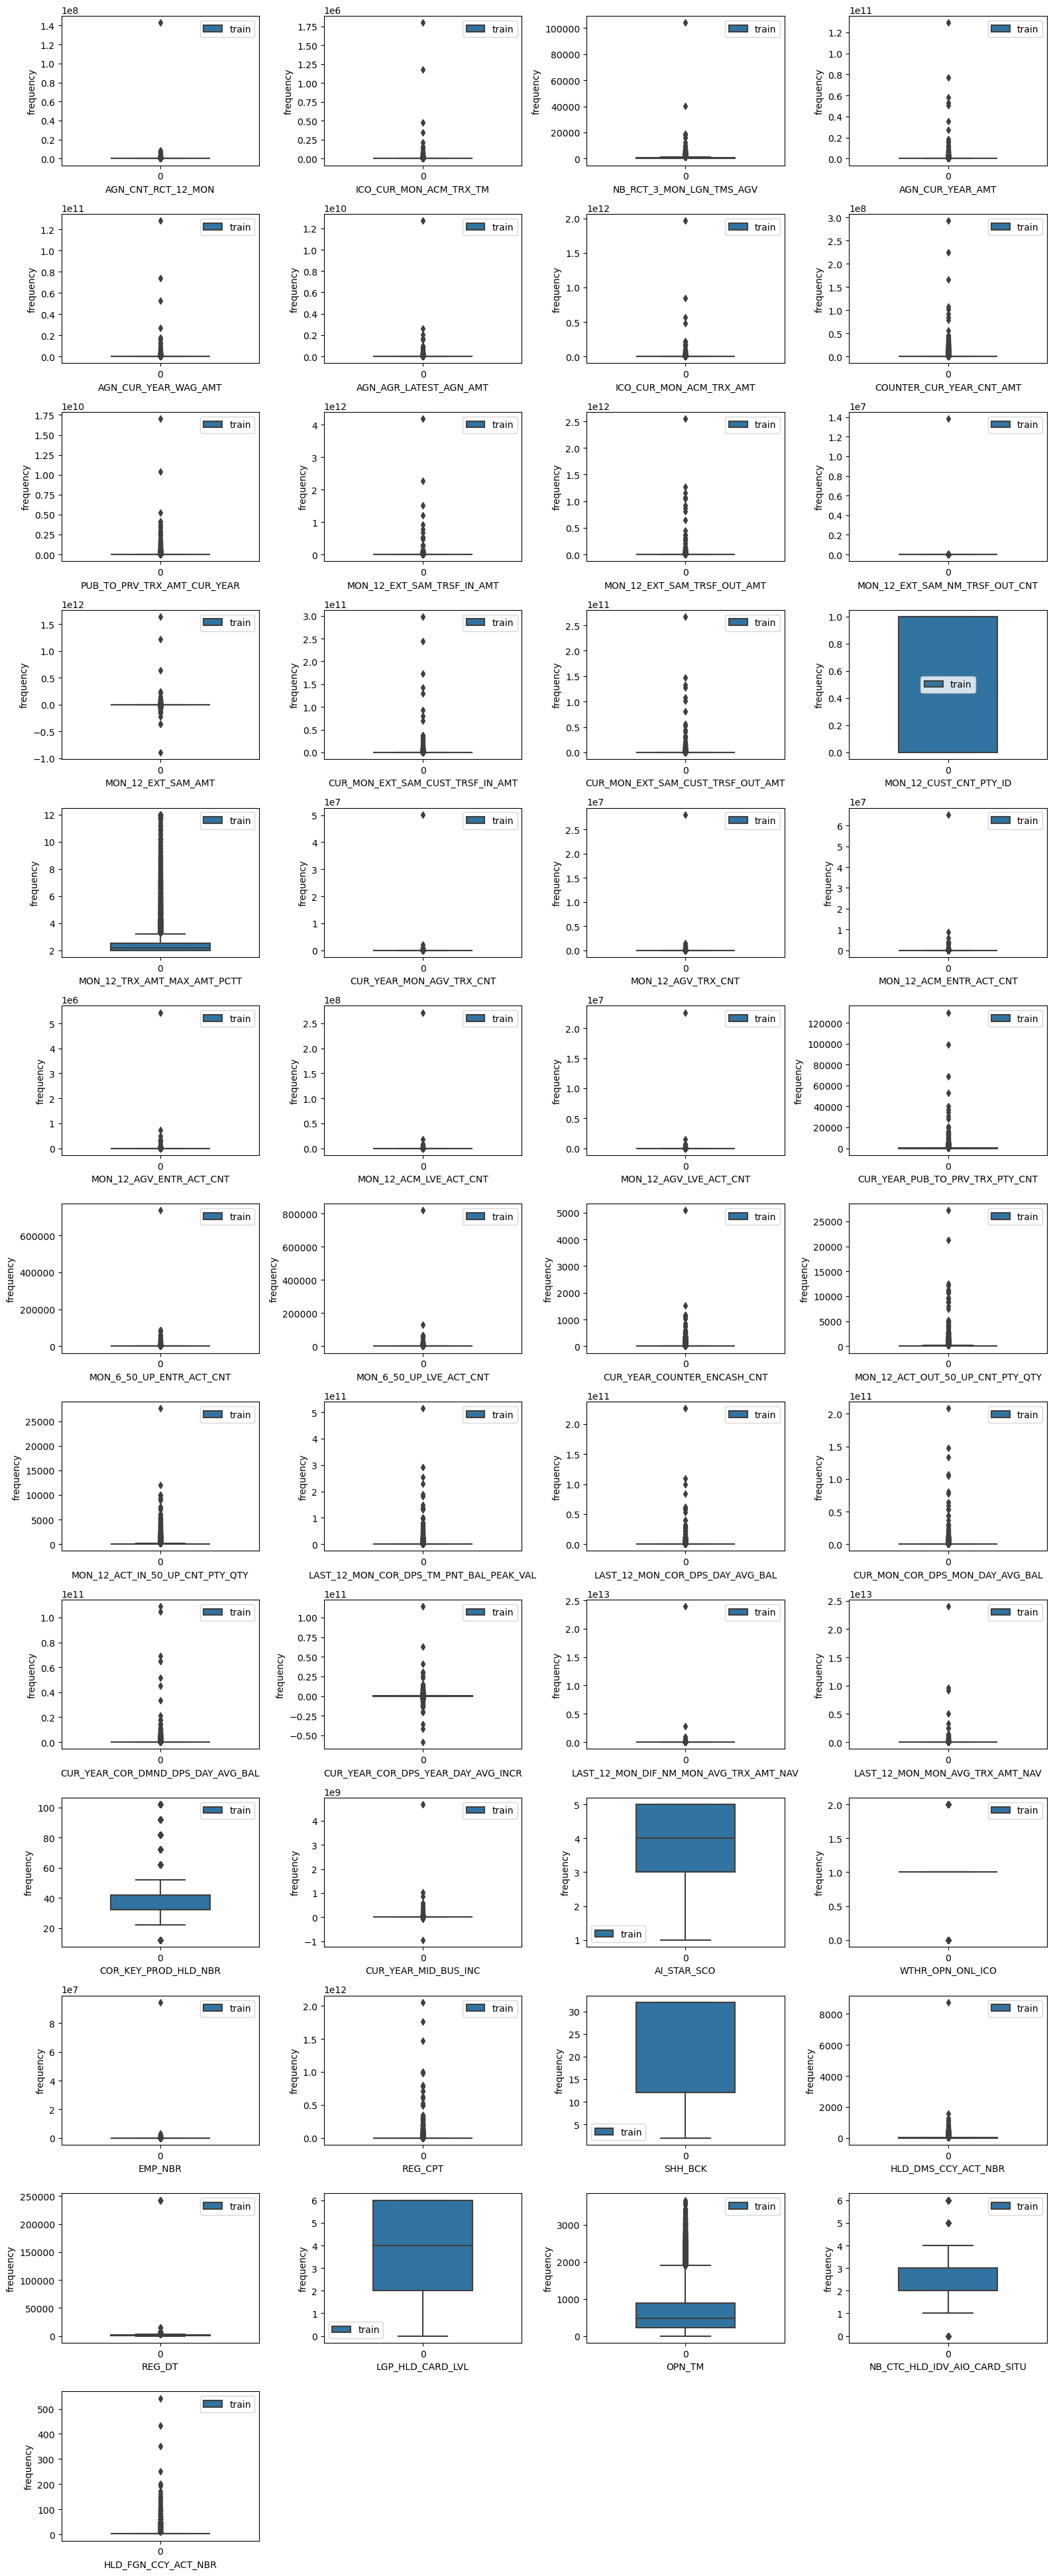

In [8]:
cols = 4
rows = 13
plt.figure(figsize = (4*cols, 3*rows))
i=1
for col in train.columns[2:]:
    if train[col].dtype != 'object':
        ax = plt.subplot(rows, cols, i)
        ax = sns.boxplot(train[col], orient = 'v', width = 0.5)
        ax.set_xlabel(col)
        ax.set_ylabel('frequency')
        ax = ax.legend(['train'])
        i += 1
plt.tight_layout()
plt.show()

## 2.3 核密度分布图

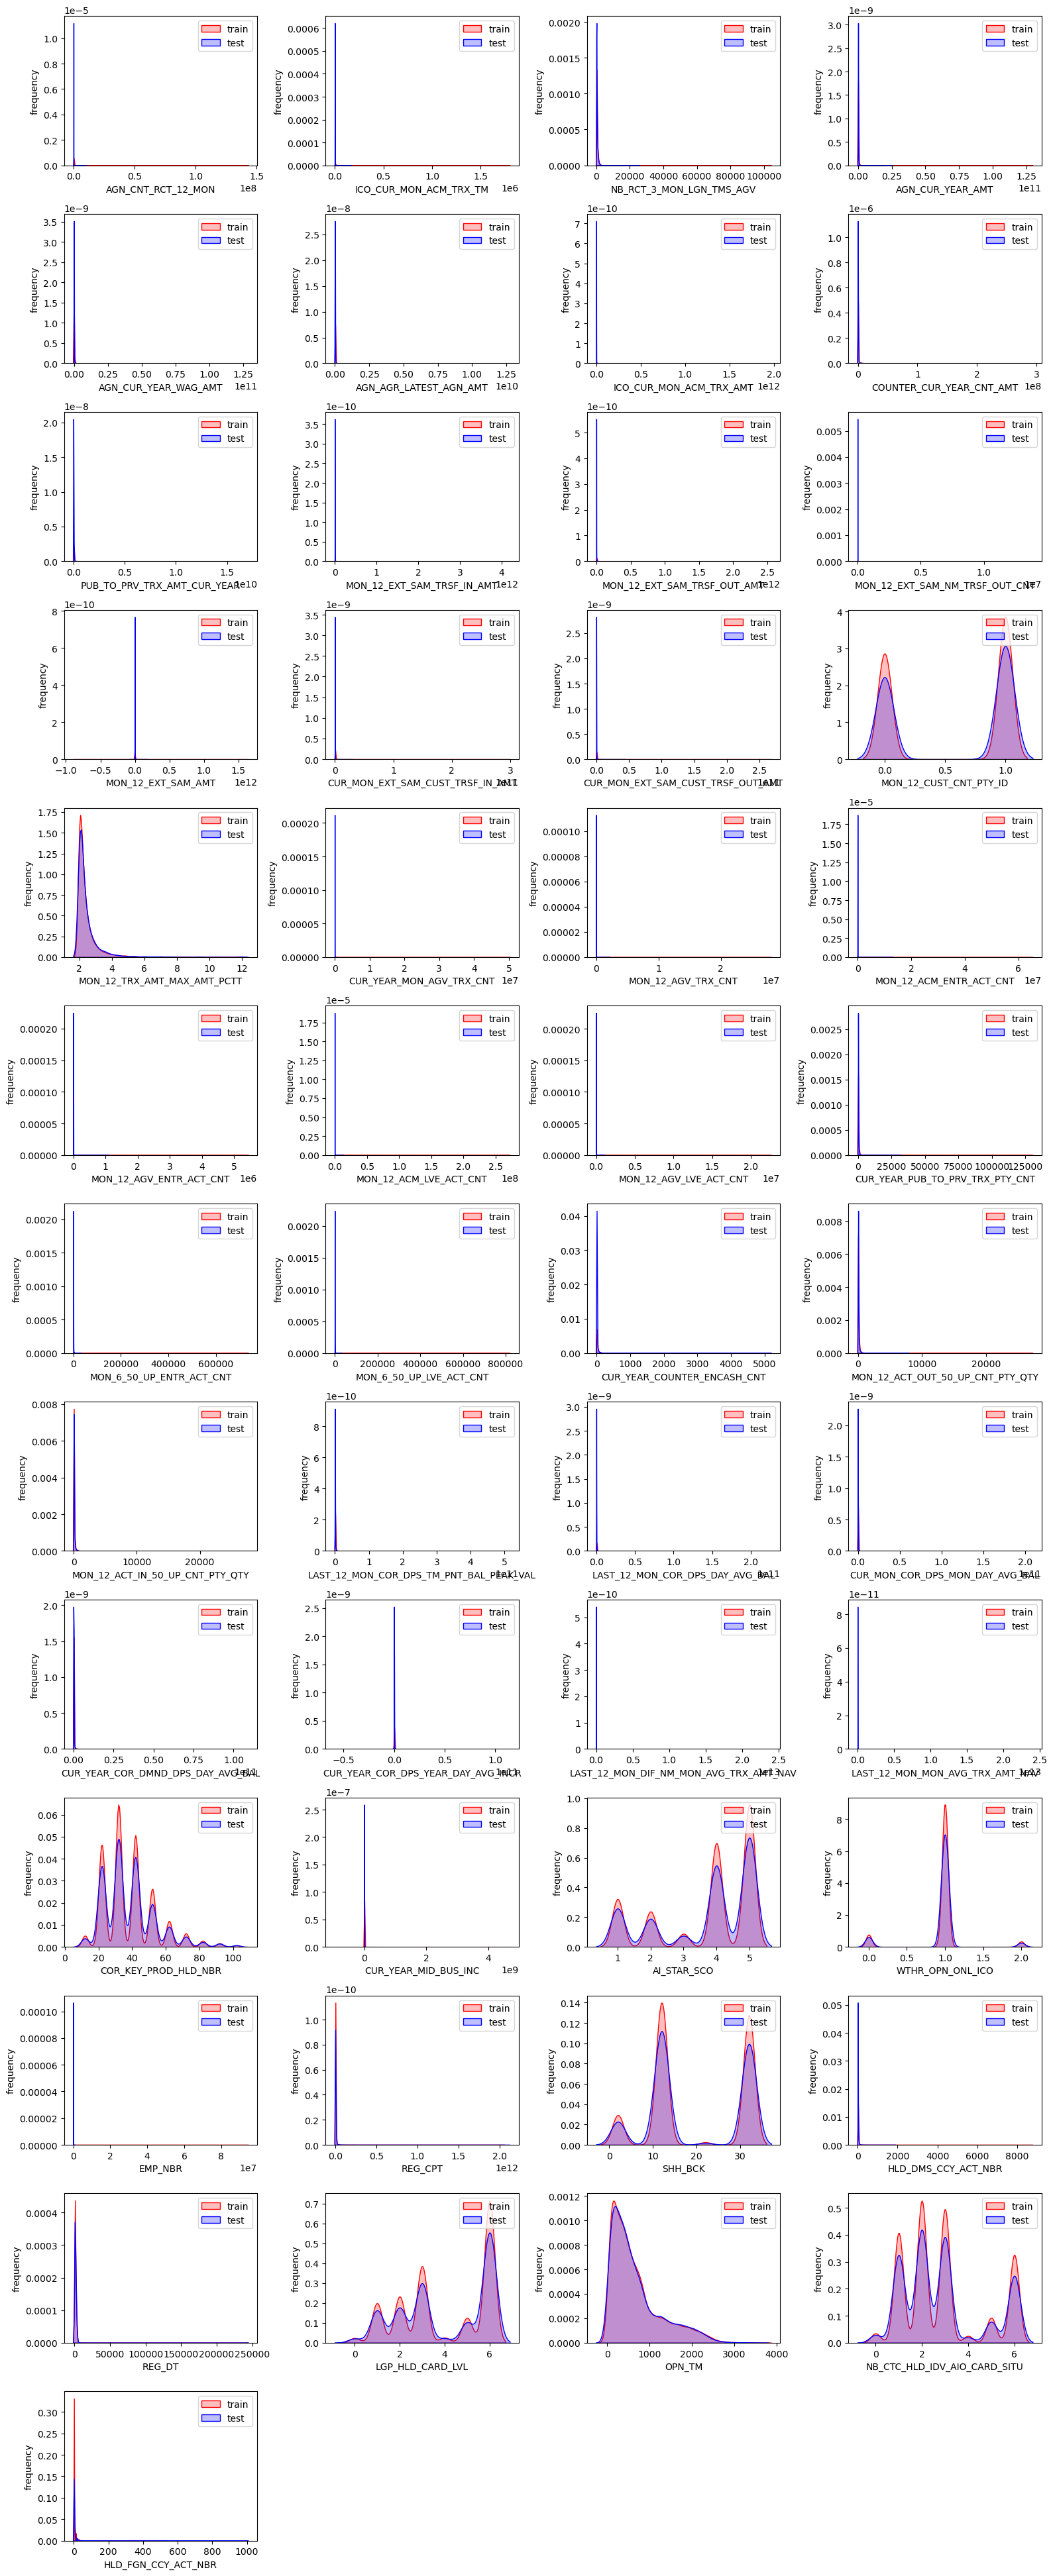

In [9]:
cols = 4
rows = 13
plt.figure(figsize = (4*cols, 3*rows))
i = 1
for col in train.columns[2:]:
    ax = plt.subplot(rows,cols,i)
    ax = sns.kdeplot(train[col].dropna(), color = 'red', shade = True)
    ax = sns.kdeplot(test[col].dropna(), color = 'blue', shade = True)
    ax.set_xlabel(col)
    ax.set_ylabel('frequency')
    ax = ax.legend(['train','test'])
    i += 1
plt.tight_layout()
plt.show()

## 2.4 对抗验证  
我们通过给训练集构造label=1, 测试集label=0, 选用lgb模型, 用所有特征来预测label, 通过交叉验证得到AUC, 判断如下:   
1.如果AUC过高，则存在训练集和测试集分布不同的特征, 即数据漂移dataset shift(该特征能准确判断训练集和测试集的差异，影响模型预测效果)  
  则删除特征重要性排名较前的特征，然后再次预测  
2.重复步骤1直至AUC达到0.5-0.6左右


In [10]:
train_new = train.copy()
test_new = test.copy()

In [11]:
train_new = train_new.drop(['CUST_UID','LABEL'], axis = 1) # 只保留特征
test_new = test_new.drop(['CUST_UID'], axis = 1)

In [14]:
train_new['label'] = 1 # 训练集标签1
test_new['label'] = 0 # 测试集标签0

In [15]:
data = pd.concat([train_new,test_new], axis = 0)

In [16]:
from sklearn.model_selection import train_test_split
test_size_pct = 0.2
X_train, X_valid, y_train, y_valid = train_test_split(data.drop(['label'],axis = 1), data['label'], test_size = test_size_pct, random_state = 42)

In [25]:
from lightgbm import LGBMClassifier
from lightgbm import log_evaluation, early_stopping
lgb = LGBMClassifier(verbosity = -1) 
lgb.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = ['auc'], 
       callbacks = [log_evaluation(period = 50), early_stopping(stopping_rounds = 128)])

Training until validation scores don't improve for 128 rounds
[50]	valid_0's auc: 0.500989	valid_0's binary_logloss: 0.534569
[100]	valid_0's auc: 0.504464	valid_0's binary_logloss: 0.536658
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.510417	valid_0's binary_logloss: 0.532726


LGBMClassifier(verbosity=-1)

In [26]:
from sklearn.metrics import roc_auc_score
pred_lgb = lgb.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, pred_lgb)

0.510416950256567

### AUC=0.51说明训练集和测试集特征分布近似，不需要删除特征

# 3. 模型初步训练
我们使用lgb对训练集的预测效果进行初步了解

In [7]:
ignore = ['CUST_UID','LABEL']
features = [feat for feat in train.columns if feat not in ignore]
target_feature = 'LABEL'

In [29]:
from sklearn.model_selection import train_test_split
test_size_pct = 0.10
X_train, X_valid, y_train, y_valid = train_test_split(train[features], train[target_feature], test_size = test_size_pct, random_state = 42)

In [33]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(verbosity = -1) 
lgb.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = ['auc'], 
       callbacks = [log_evaluation(period = 50), early_stopping(stopping_rounds = 128)])

Training until validation scores don't improve for 128 rounds
[50]	valid_0's auc: 0.949571	valid_0's binary_logloss: 0.240469
[100]	valid_0's auc: 0.949393	valid_0's binary_logloss: 0.240118
Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.949871	valid_0's binary_logloss: 0.239181


LGBMClassifier(verbosity=-1)

In [34]:
from sklearn.metrics import roc_auc_score
pred_lgb = lgb.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, pred_lgb)

0.9498706534679444

# 4. K折交叉验证

In [35]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(learning_rate = 0.05, max_depth = 20, num_leaves = 100, random_state = 1000, verbosity = -1)
strtfdKFold = StratifiedKFold(n_splits = 5, random_state = 100, shuffle = True)
# 把特征和标签传递给StratifiedKFold实例
X_train = train[features]
y_train = train[target_feature]
kfold = strtfdKFold.split(X_train, y_train)
scores = []
for k, (train1, test1) in enumerate(kfold):
    lgb.fit(X_train.iloc[train1,:], y_train.iloc[train1])
    pred_lgb = lgb.predict_proba(X_train.iloc[test1, :])[:,1]
    score = roc_auc_score(y_train.iloc[test1], pred_lgb)
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, AUC: %s' % (k+1, np.bincount(y_train.iloc[train1]), score))
print('Cross-Validation AUC: %s +/- %s' %(np.mean(scores), np.std(scores)))

Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9490365000000001
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9481471250000001
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.9523520416666665
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9509735416666666
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9490646666666667
Cross-Validation AUC: 0.9499147749999999 +/- 0.0015283908750980848


# 5. 多模型预测

## 5.1 单模效果检验

In [42]:
from sklearn import model_selection, ensemble
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tqdm import tqdm
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('hgbc', ensemble.HistGradientBoostingClassifier(random_state = 42)),
    #lightbgm
    ('lgb', LGBMClassifier(verbosity = -1, random_state = 42)),
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    ('xgb', XGBClassifier(verbosity = 0, random_state = 42)),
    ('cbc', CatBoostClassifier(verbose = 0, random_state = 42))
]

In [41]:
MLA_columns = ['MLA Name','MLA Train AUC Mean', 'MLA Test AUC Mean', 'MLA Test AUC 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0
cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = 0.2, train_size = 0.8, random_state = 0)
for i in tqdm(vote_est):
    model = i[1]
    MLA_compare.loc[row_index, 'MLA Name'] = i[0]
    cv_results = model_selection.cross_validate(model, train[features], train[target_feature], cv = cv_split, scoring = 'roc_auc', return_train_score = True)
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train AUC Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test AUC Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test AUC 3*STD'] = cv_results['test_score'].std()*3   # let's know the worst that can happen!
    row_index += 1
    del model
MLA_compare.sort_values(by = ['MLA Test AUC Mean'], ascending = False, inplace = True)
MLA_compare

100%|██████████| 4/4 [01:20<00:00, 20.21s/it]


,MLA Name,MLA Train AUC Mean,MLA Test AUC Mean,MLA Test AUC 3*STD,MLA Time
1,lgb,0.976829,0.950642,0.007759,0.365629
3,cbc,0.979338,0.950619,0.007465,14.070166
0,hgbc,0.970688,0.950087,0.007439,0.70215
2,xgb,0.994984,0.947138,0.007695,0.768368


## 5.2 软投票

In [43]:
grid_soft = ensemble.VotingClassifier(estimators = vote_est, voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, train[features], train[target_feature],
                                              scoring='roc_auc', cv = cv_split, return_train_score = True)

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))

Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 98.52
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 95.20
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 0.71


In [44]:
grid_soft.fit(train[features], train[target_feature])
pred = grid_soft.predict_proba(test[features])[:,1]
sub = pd.DataFrame(test['CUST_UID'])
sub['prob'] = pred
with open('test_grid_soft.txt','w') as file:
    for i in sub.index:
        file.write(sub.loc[i,'CUST_UID'] + ' ' + str(sub.loc[i,'prob']) + '\n') # online score:0.95323

### 测试删去单模效果最差的xgboost

In [56]:
vote_est2 = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('hgbc', ensemble.HistGradientBoostingClassifier(random_state = 42)),
    #lightbgm
    ('lgb', LGBMClassifier(verbosity = -1, random_state = 42)),
    ('cbc', CatBoostClassifier(verbose = 0, random_state = 42))
]

In [57]:
grid_soft2 = ensemble.VotingClassifier(estimators = vote_est2 , voting = 'soft')
grid_soft_cv2 = model_selection.cross_validate(grid_soft2, train[features], train[target_feature],
                                               scoring='roc_auc', cv = cv_split, return_train_score = True)

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv2['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv2['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv2['test_score'].std()*100*3))

Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 97.77
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 95.18
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 0.70


### 与删除前相比之下没有显著差异

## 5.3 模型融合stacking

In [58]:
from mlxtend.classifier import StackingCVClassifier

In [59]:
train_new = train.copy()
test_new = test.copy()
dataset_net = [train_new,test_new]
for dataset in dataset_net:
    for i in dataset.columns:
        if dataset[i].dtype != 'object':
            dataset[i] = dataset[i].fillna(dataset[i].mean())

In [60]:
hgbc = ensemble.HistGradientBoostingClassifier(random_state = 42)
lgb = LGBMClassifier(verbosity = -1, random_state = 42)
xgb = XGBClassifier(verbosity = 0, random_state = 42)
cbc = CatBoostClassifier(verbose = 0, random_state = 42)
lr = linear_model.LogisticRegressionCV()
sclf = StackingCVClassifier(classifiers = [hgbc, lgb, cbc],  # 第一层分类器
                            meta_classifier = lr,   # 第二层分类器，并非表示第二次stacking，而是通过logistic regression对新的训练特征数据进行训练，得到predicted label
                            cv = 5)

In [61]:
from sklearn.model_selection import StratifiedKFold
strtfdKFold = StratifiedKFold(n_splits = 5)
#把特征和标签传递给StratifiedKFold实例
X_train = train_new[features]
y_train = train_new[target_feature]
kfold = strtfdKFold.split(X_train, y_train)
scores = []
for k, (train1, test1) in enumerate(kfold):
    sclf.fit(X_train.iloc[train1,:], y_train.iloc[train1])
    pred_lgb = sclf.predict_proba(X_train.iloc[test1, :])[:,1]
    score = roc_auc_score(y_train.iloc[test1], pred_lgb)
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train.iloc[train1]), score))
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Fold:  1, Training/Test Split Distribution: [24000  8000], Accuracy: 0.893
Fold:  2, Training/Test Split Distribution: [24000  8000], Accuracy: 0.882
Fold:  3, Training/Test Split Distribution: [24000  8000], Accuracy: 0.883
Fold:  4, Training/Test Split Distribution: [24000  8000], Accuracy: 0.880
Fold:  5, Training/Test Split Distribution: [24000  8000], Accuracy: 0.882


Cross-Validation accuracy: 0.884 +/- 0.005


### 简单试了几个stacking，发现效果远远不如单模，故选用软投票

# 6. 伪标签

## 6.1 自定义伪标签回归类库

In [62]:
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

class PseudoLabeler(BaseEstimator, RegressorMixin):
    
    def __init__(self, model, test, features, target, sample_rate=0.2, seed=42):
        self.sample_rate = sample_rate
        self.seed = seed
        self.model = model
        self.model.seed = seed
        
        self.test = test
        self.features = features
        self.target = target
        
    def get_params(self, deep=True):
        return {
            "sample_rate": self.sample_rate,
            "seed": self.seed,
            "model": self.model,
            "test": self.test,
            "features": self.features,
            "target": self.target
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

        
    def fit(self, X, y):
        if self.sample_rate > 0.0:
            augemented_train = self.__create_augmented_train(X, y)
            self.model.fit(
                augemented_train[self.features],
                augemented_train[self.target]
            )
        else:
            self.model.fit(X, y)
        
        return self


    def __create_augmented_train(self, X, y):
        num_of_samples = int(len(self.test) * self.sample_rate)
        
        # Train the model and creat the pseudo-labels
        self.model.fit(X, y)
        pseudo_labels = self.model.predict(self.test[self.features])
        
        # Add the pseudo-labels to the test set
        augmented_test = self.test.copy(deep=True)
        augmented_test[self.target] = pseudo_labels
        
        # Take a subset of the test set with pseudo-labels and append in onto
        # the training set
        sampled_test = augmented_test.sample(n=num_of_samples)
        temp_train = pd.concat([X, y], axis=1)
        augemented_train = pd.concat([sampled_test, temp_train])

        return shuffle(augemented_train)
        
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def get_model_name(self):
        return self.model.__class__.__name__

In [63]:
strtfdKFold = StratifiedKFold(n_splits = 5)
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
X_train = train[features]
y_train = train[target_feature]
X_test = test[features]
kfold = strtfdKFold.split(X_train, y_train)
pred = pd.DataFrame()
for k, (train1, test1) in enumerate(kfold):
    pseudo = PseudoLabeler(grid_soft, test, features, target_feature, sample_rate = 1)
    pseudo.fit(X_train.iloc[train1,:], y_train.iloc[train1])
    pred_lgb = pseudo.predict_proba(X_test)[:,1]
    pred[str(k)] = pred_lgb

In [64]:
pred['result'] = (pred['0'] + pred['1'] + pred['2'] + pred['3'] + pred['4']) / 5
sub = pd.DataFrame(test['CUST_UID'])
sub['prob'] = pred['result']
with open('test_grid_soft_pseudo.txt','w') as file:
    for i in sub.index:
        file.write(sub.loc[i,'CUST_UID']+' '+str(sub.loc[i,'prob'])+'\n') # score: 0.95344

# 7. 神经网络

In [57]:
import os, gc, math, time, random, numpy as np, pandas as pd, warnings, torch
warnings.filterwarnings('ignore')
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from transformers import get_constant_schedule_with_warmup, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ====================================================
# CFG
# ====================================================
class CFG:
    seed = 42
    num_hidden1 = 768
    num_hidden2 = 512
    num_hidden3 = 768
    num_hidden4 = 768
    num_output = 2
    print_freq = 100
    scheduler = 'cosine'
    batch_size = 32
    num_workers = 3
    lr = 1e-5
    weight_decay = 0
    epochs = 5
    num_warmup_steps = 0
    num_cycles = 0.5
    n_accumulate = 1
    train = True
    n_fold = 5

def seed_everything(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed = 42)
train_net = pd.read_excel('fintech训练营/train.xlsx')
for i in train_net.columns:
    train_net[i] = train_net[i].apply(lambda x : np.nan if x=='?' else x)
label = LabelEncoder()
for i in train_net.columns:
    if train_net[i].dtype == 'object':
        if i != 'CUST_UID':
            train_net[i] = label.fit_transform(train_net[i])
    else:
        if i != "LABEL":
            train_net[i] = train_net[i].fillna(train_net[i].mode().values[0]) # 用众数填充缺失值
            train_net[i] = (train_net[i] - train_net[i].min()) / (train_net[i].max() - train_net[i].min()) # 归一化

ignore = ['CUST_UID','LABEL']
CFG.feas = [feat for feat in train_net.columns if feat not in ignore]
CFG.target_fea = 'LABEL'

skf = StratifiedKFold(n_splits = 5, random_state = CFG.seed, shuffle = True)
train_net['fold'] = -1
for i, (_, val_) in enumerate(skf.split(train_net[CFG.feas], train_net[CFG.target_fea])):
    train_net.loc[val_, 'fold'] = int(i)


In [58]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss(reduction = 'sum')(outputs, labels)
    # return nn.MSELoss(reduction = 'mean')(outputs, labels)

def get_score(outputs, labels):
    outputs = F.softmax(torch.tensor(outputs)).numpy()[:,1]
    return roc_auc_score(labels, outputs)

class FeedBackDataset(Dataset):
    def __init__(self, data):
        self.data = data[CFG.feas].values
        self.targets = data[CFG.target_fea].values

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return {
            'feature': self.data[index], 
            'target': self.targets[index]
        }

def custom_collate_fn(batch):
    datas, targets = [], []
    for batchid, data in enumerate(batch):
        datas.append(data['feature'])
        targets.append(data['target'])
    datas = torch.tensor(datas) 
    targets = torch.tensor(targets) 
    return datas, targets

class BPNetModel(nn.Module):
    def __init__(self):
        super(BPNetModel, self).__init__()
        self.hiddden1 = torch.nn.Linear(len(CFG.feas), CFG.num_hidden1) # 定义隐层网络
        self.hiddden2 = torch.nn.Linear(CFG.num_hidden1, CFG.num_hidden2)
        self.hiddden3 = torch.nn.Linear(CFG.num_hidden2, CFG.num_hidden3) # 定义隐层网络
        self.hiddden4 = torch.nn.Linear(CFG.num_hidden3, CFG.num_hidden4)
        self.out = torch.nn.Linear(CFG.num_hidden4, CFG.num_output) # 定义输出层网络
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.hiddden1(x) # 隐层激活函数采用relu()函数
        x = self.relu(x)
        x = self.hiddden2(x)
        x = self.relu(x)
        x = self.hiddden3(x)
        x = self.relu(x)
        x = self.hiddden4(x)
        x = self.relu(x)
        x = self.out(x)
        return x

    def get_loss(self, inputs):
        inputs, targets = inputs[0].to(device), inputs[1]
        outs = self.forward(inputs)
        loss = criterion(outs, targets.to(device))
        return loss, outs

    def loss_accumulate(self, data_list):
        running_loss = 0
        result = []
        all_bs = sum(data_bts['batchsize'] for data_bts in data_list)
        for data_bts in data_list:
            data = data_bts['data']
            loss, outs = self.get_loss(data)
            loss = loss / all_bs
            loss.backward()
            running_loss += loss.item()
            result.append(outs.detach().to('cpu').numpy())
        return running_loss, all_bs, result

def asMinutes(s):
    m = math.floor(s/60)
    s -= m * 60
    return "%dm %ds" % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.scheduler == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps = cfg.num_warmup_steps, num_training_steps = num_train_steps
        )
    elif cfg.scheduler == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps = cfg.num_warmup_steps, num_training_steps = num_train_steps, num_cycles = cfg.num_cycles
        )
    return scheduler


def train_one_epoch(model, optimizer, scheduler, dataloader, epoch, valid_data):
    model.train()
    dataset_size = 0
    running_loss_awp = 0
    epoch_loss_awp = 0
    # valid_labels = valid_data.label.values
    validDataset = FeedBackDataset(valid_data)
    valid_loader = DataLoader(validDataset,
                            batch_size = CFG.batch_size,
                            shuffle = False,
                            collate_fn = custom_collate_fn,
                            num_workers = CFG.num_workers,
                            pin_memory = True)

    start = end = time.time()
    data_list = []
    target_list = []
    pred_list = []
    for step, data in enumerate(dataloader):
        if os.path.exists('break.txt'):
            raise ValueError('break error')

        batch_size = data[-1].shape[0]
        data_list.append({'data': data, 'batchsize': batch_size})
        target_list.append(data[1].numpy())
        if (step +1) % CFG.n_accumulate == 0:
            accum_loss, datalist_size, result = model.loss_accumulate(data_list)
            optimizer.step()
            optimizer.zero_grad()
            if scheduler is not None:
                scheduler.step()
            pred_list += result
            data_list = [] # refresh the accumulate data_list
            running_loss_awp += (accum_loss * datalist_size)
            dataset_size += datalist_size
            # average loss
            epoch_loss_awp = running_loss_awp / dataset_size

        end = time.time()

        if step % CFG.print_freq == 0 or step == (len(dataloader)-1):
            score_train = get_score(np.concatenate(pred_list), np.concatenate(target_list))
            print('Train: [{}] '
                  'Loss: {:.4f}  ' 
                  'Train AUC: {:.4f}  ' 
                  'Step: [{}/{}] '
                  'Elapsed {remain:s} '
                  .format(epoch, epoch_loss_awp, score_train, step+1, len(dataloader), 
                          remain = timeSince(start, float(step+1)/len(dataloader))))
    pred = valid_one_epoch(model, valid_loader, epoch)

    gc.collect()
    return epoch_loss_awp, pred

@torch.no_grad()
def valid_one_epoch(model, dataloader, epoch):
    dataset_size = 0
    running_loss = 0

    start = end = time.time()
    pred = []

    for step, data in enumerate(dataloader):
        if os.path.exists('break.txt'):
            raise ValueError('break error')
        loss, outputs = model.get_loss(data)
        pred.append(outputs.to('cpu').numpy())
        batch_size = data[-1].shape[0]
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size

    print('EVAL: [{}] ' 
            'Loss: {:.4f}  '
            'Step: [{}/{}] '
            'Elapsed {remain:s} '
            .format(epoch, epoch_loss, step + 1 , len(dataloader),
                    remain = timeSince(start, float(step+1)/len(dataloader))))
    pred = np.concatenate(pred)
    model.train()
    return pred


def train_loop(fold):
    train_data = train_net[train_net.fold != fold].reset_index(drop=True)
    valid_data = train_net[train_net.fold == fold].reset_index(drop=True)
    trainDataset = FeedBackDataset(train_data)
    train_loader = DataLoader(trainDataset,
                              batch_size = CFG.batch_size,
                              shuffle = True,
                              collate_fn = custom_collate_fn,
                              num_workers = CFG.num_workers,
                              pin_memory = True)

    model = BPNetModel().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = CFG.lr)
    # loop
    best_score = 0
    # General training
    num_train_steps = int(len(train_data) / CFG.batch_size * CFG.epochs) 
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)
    for epoch in range(CFG.epochs):
        print(f'-------------epoch:{epoch} training-------------')
        start_time = time.time()
        train_epoch_loss, pred = train_one_epoch(model, optimizer, scheduler, train_loader, epoch, valid_data)
        score = get_score(pred, valid_data[CFG.target_fea].values)
        elapsed = time.time() - start_time
        print(f'Fold {fold} Epoch {epoch} - avg_train_loss: {train_epoch_loss:.4f} time: {elapsed:.0f}s')
        if score > best_score:
            best_score = score
        print(f'AUC score:{score}  best_score:{best_score}')
    torch.cuda.empty_cache()
    gc.collect()
    
    return best_score

In [ ]:
best_scores = []
if CFG.train:
    for fold in range(CFG.n_fold):
        print(f'-------------fold:{fold} training-------------')
        best_scores.append(train_loop(fold))
    print(f"Cross Validation: {np.mean(best_scores)}")

#### 部分日志展示：  
-------------epoch:4 training-------------  
Train: [4] Loss: 0.5875  Test AUC: 0.6727  Step: [1/1000] Elapsed 0m 0s (remain 1m 12s)   
Train: [4] Loss: 0.5156  Test AUC: 0.6763  Step: [101/1000] Elapsed 0m 0s (remain 0m 2s)   
Train: [4] Loss: 0.5246  Test AUC: 0.6699  Step: [201/1000] Elapsed 0m 0s (remain 0m 2s)   
Train: [4] Loss: 0.5281  Test AUC: 0.6632  Step: [301/1000] Elapsed 0m 0s (remain 0m 1s)   
Train: [4] Loss: 0.5335  Test AUC: 0.6615  Step: [401/1000] Elapsed 0m 0s (remain 0m 1s)     
Train: [4] Loss: 0.5364  Test AUC: 0.6585  Step: [501/1000] Elapsed 0m 1s (remain 0m 1s)     
Train: [4] Loss: 0.5355  Test AUC: 0.6569  Step: [601/1000] Elapsed 0m 1s (remain 0m 0s)   
Train: [4] Loss: 0.5337  Test AUC: 0.6572  Step: [701/1000] Elapsed 0m 1s (remain 0m 0s)   
Train: [4] Loss: 0.5336  Test AUC: 0.6570  Step: [801/1000] Elapsed 0m 1s (remain 0m 0s)   
Train: [4] Loss: 0.5325  Test AUC: 0.6593  Step: [901/1000] Elapsed 0m 1s (remain 0m 0s)   
Train: [4] Loss: 0.5325  Test AUC: 0.6598  Step: [1000/1000] Elapsed 0m 2s (remain 0m 0s)   
EVAL: [4] Loss: 17.1514  Step: [250/250] Elapsed 0m 0s (remain 0m 0s)   
Fold 4 Epoch 4 - avg_train_loss: 0.5325 time: 2s  
AUC score:0.6505471666666667  best_score:0.6507739583333333  
Cross Validation: 0.6568245416666667  

### baseline模型效果不好，故不用nn

# 8. Bad case分析

In [578]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
strtfdKFold = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
#把特征和标签传递给StratifiedKFold实例
X_train=train[features]
y_train=train[target_feature]
kfold = strtfdKFold.split(X_train, y_train)
scores = []
train_pred=pd.DataFrame()
for k, (train1, test1) in enumerate(kfold):
    train_copy=train.iloc[test1,:].copy()
    grid_soft.fit(X_train.iloc[train1,:], y_train.iloc[train1])
    pred_pro_grid = grid_soft.predict_proba(X_train.iloc[test1, :])[:,1]
    pred_grid=grid_soft.predict(X_train.iloc[test1, :])
    train_copy['pred']=pred_grid
    train_copy['prob']=pred_pro_grid
    train_pred=pd.concat([train_pred,train_copy],axis=0)
    score=roc_auc_score(y_train.iloc[test1], pred_pro_grid)
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, AUC: %.3f' % (k+1, np.bincount(y_train.iloc[train1]), score))
print('\n\nCross-Validation AUC: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.951
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.950
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.953
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.952
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.951


Cross-Validation AUC: 0.951 +/- 0.001
Wall time: 2min 13s


In [579]:
false_positive=train_pred[(train_pred['LABEL']==0) & (train_pred['pred']==1)]
false_negative=train_pred[(train_pred['LABEL']==1) & (train_pred['pred']==0)]
true_positive=train_pred[(train_pred['LABEL']==1) & (train_pred['pred']==1)]
true_negative=train_pred[(train_pred['LABEL']==0) & (train_pred['pred']==0)]

In [581]:
false_positive.to_csv('false_positive.csv',index=False)
false_negative.to_csv('false_negative.csv',index=False)
true_positive.to_csv('true_positive.csv',index=False)
true_negative.to_csv('true_negative.csv',index=False)

### bad case很难发现什么规律

# 9. 分箱

## 9.1 五段分箱

In [51]:
%%time
result = pd.DataFrame([0.9512318000000001],columns=['no_cut'])
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
for name in train.columns[2:]:
    train_cut=train.copy()
    if train[name].dtype!='object':
        train_cut[name] = pd.qcut(train_cut[name].rank(method='first'),5)
        train_cut[name] = label.fit_transform(train_cut[name])
        print(name)
        strtfdKFold = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
        #把特征和标签传递给StratifiedKFold实例
        X_train = train_cut[features]
        y_train = train_cut[target_feature]
        kfold = strtfdKFold.split(X_train, y_train)
        scores = []
        for k, (train1, test1) in enumerate(kfold):
            grid_soft.fit(X_train.iloc[train1,:], y_train.iloc[train1])
            pred_lgb = grid_soft.predict_proba(X_train.iloc[test1, :])[:,1]
            score=roc_auc_score(y_train.iloc[test1], pred_lgb)
            scores.append(score)
            print('Fold: %2d, Training/Test Split Distribution: %s, AUC: %s' % (k+1, np.bincount(y_train.iloc[train1]), score))
        print('Cross-Validation AUC: %s +/- %s\n' %(np.mean(scores), np.std(scores)))
        result[name] = np.mean(scores)
        

AGN_CNT_RCT_12_MON
Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9506880833333332
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9503696666666666
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.9533309166666668
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9519149166666666
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9506939583333334
Cross-Validation AUC: 0.9513995083333333 +/- 0.0011009526866916214

ICO_CUR_MON_ACM_TRX_TM
Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9504041666666665
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9506532499999999
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.953225625
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.951189
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9505192083333334
Cross-Validation AUC: 0.9511982499999998 +/- 0.0010487159652138825

NB_RCT_3_

Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.9531089583333334
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9515739999999999
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9503573333333334
Cross-Validation AUC: 0.9510425916666667 +/- 0.001170686561500488

CUR_YEAR_MON_AGV_TRX_CNT
Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.949728
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9497898333333333
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.953205
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9514988333333333
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9504735416666665
Cross-Validation AUC: 0.9509390416666668 +/- 0.001300148133120044

MON_12_AGV_TRX_CNT
Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9504385000000001
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9500204999999999
Fold:  3, Tr

Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9491013333333332
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9496224166666668
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.9532391666666665
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9518687499999999
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9506814999999998
Cross-Validation AUC: 0.9509026333333332 +/- 0.0015050120123181992

LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV
Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9496246666666668
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9505190833333333
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.9531686666666666
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9513435
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9501914583333334
Cross-Validation AUC: 0.9509694750000002 +/- 0.00123231576536023

LAST_1

In [62]:
cut_name_5=pd.DataFrame(columns=['name','auc'])
index=0
for i in result.columns[1:]:
    if result[i][0]>result['no_cut'][0]: # 找到分箱提升的列
        cut_name_5.loc[index,'name']=i
        cut_name_5.loc[index,'auc']=result[i][0]
        index+=1

In [63]:
train_cut=train.copy()
test_cut=test.copy()
dataset_cut=[train_cut,test_cut]
for dataset in dataset_cut:
    for name in cut_name_5['name']:
        dataset[name]=pd.qcut(dataset[name].rank(method='first'),5)
        dataset[name]=label.fit_transform(dataset[name])

In [65]:
train_cut.to_csv('train_cut.csv',index=False)
test_cut.to_csv('test_cut.csv',index=False)

In [672]:
%%time
strtfdKFold = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
#把特征和标签传递给StratifiedKFold实例
X_train=train_cut[features]
y_train=train_cut[target_feature]
kfold = strtfdKFold.split(X_train, y_train)
scores = []
for k, (train1, test1) in enumerate(kfold):
    grid_soft.fit(X_train.iloc[train1,:], y_train.iloc[train1])
    pred_grid_soft = grid_soft.predict_proba(X_train.iloc[test1, :])[:,1]
    score=roc_auc_score(y_train.iloc[test1], pred_grid_soft)
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, AUC: %s' % (k+1, np.bincount(y_train.iloc[train1]), score))
print('\nCross-Validation AUC: %s +/- %s' %(np.mean(scores), np.std(scores)))

Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9505004999999999
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.950264875
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.9532870000000001
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9516154166666667
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9503165833333334

Cross-Validation AUC: 0.9511968749999999 +/- 0.001155186149621741
Wall time: 1min 50s


In [605]:
%%time
# 预测测试集
strtfdKFold = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
X_train=train_cut[features]
y_train=train_cut[target_feature]
X_test=test_cut[features]
kfold = strtfdKFold.split(X_train, y_train)
pred_cut_grid=pd.DataFrame()
for k, (train1, test1) in enumerate(kfold):
    pseudo = PseudoLabeler(grid_soft, test_cut, features, target_feature, sample_rate=1)
    pseudo.fit(X_train.iloc[train1,:], y_train.iloc[train1])
    pred_grid_prob = pseudo.predict_proba(X_test)[:,1]
    pred_cut_grid[str(k)]=pred_grid_prob

Wall time: 4min 58s


In [608]:
%%time
pred_cut_grid['result']=(pred_cut_grid['0']+pred_cut_grid['1']+pred_cut_grid['2']+pred_cut_grid['3']+pred_cut_grid['4'])/5
sub=pd.DataFrame(test['CUST_UID'])
sub['prob']=pred_cut_grid['result']
with open('test_grid_soft_pseudo_cut.txt','w') as file:
    for i in sub.index:
        file.write(sub.loc[i,'CUST_UID']+' '+str(sub.loc[i,'prob'])+'\n') # score: score=0.95347

Wall time: 213 ms


## 9.2 四段分箱

In [638]:
%%time
result=pd.DataFrame([0.9512515333333333],columns=['no_cut'])
for name in train.columns[2:]:
    train_cut=train.copy()
    if train[name].dtype!='object':
        train_cut[name]=pd.qcut(train_cut[name].rank(method='first'),4)
        train_cut[name]=label.fit_transform(train_cut[name])
        print(name)
        strtfdKFold = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
        #把特征和标签传递给StratifiedKFold实例
        X_train=train_cut[features]
        y_train=train_cut[target_feature]
        kfold = strtfdKFold.split(X_train, y_train)
        scores = []
        for k, (train1, test1) in enumerate(kfold):
            grid_soft.fit(X_train.iloc[train1,:], y_train.iloc[train1])
            pred_lgb = grid_soft.predict_proba(X_train.iloc[test1, :])[:,1]
            score=roc_auc_score(y_train.iloc[test1], pred_lgb)
            scores.append(score)
            print('Fold: %2d, Training/Test Split Distribution: %s, AUC: %s' % (k+1, np.bincount(y_train.iloc[train1]), score))
        print('Cross-Validation AUC: %s +/- %s\n' %(np.mean(scores), np.std(scores)))
        result[name]=np.mean(scores)
        

AGN_CNT_RCT_12_MON
Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9494864166666667
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9502543333333333
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.9532059166666668
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9517043333333334
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9503854999999999
Cross-Validation AUC: 0.9510072999999999 +/- 0.001310454186108397

ICO_CUR_MON_ACM_TRX_TM
Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9501418333333334
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9501595833333333
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.953224
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9517373333333334
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9499528333333334
Cross-Validation AUC: 0.9510431166666666 +/- 0.0012664793278130413

NB_

Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.953290875
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9519058333333333
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9504870000000002
Cross-Validation AUC: 0.9512045083333334 +/- 0.0012341699292101344

CUR_YEAR_MON_AGV_TRX_CNT
Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.94955975
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.94987625
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.9531373333333335
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.95167725
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9506189999999999
Cross-Validation AUC: 0.9509739166666668 +/- 0.001304281776602717

MON_12_AGV_TRX_CNT
Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9500292499999999
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9499510833333332
Fold:  3, Training/Tes

Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9432856666666668
Cross-Validation AUC: 0.9435050166666666 +/- 0.0012004471035132382

CUR_YEAR_COR_DPS_YEAR_DAY_AVG_INCR
Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9498393333333334
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9499260833333333
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.9532199166666668
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9515073333333333
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9503370000000001
Cross-Validation AUC: 0.9509659333333333 +/- 0.0012743333588369093

LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV
Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9502002500000001
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.95000675
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.9530885
Fold:  4, Training/Test Split Distribution: [24000  8000], A

In [639]:
cut_name_4=pd.DataFrame(columns=['name','auc'])
index=0
for i in result.columns[1:]:
    if result[i][0]>result['no_cut'][0]: # 找到分箱提升的列
        cut_name_4.loc[index,'name']=i
        cut_name_4.loc[index,'auc']=result[i][0]
        index+=1

In [657]:
cut_name_4['cut']=4
cut_name_5['cut']=5

In [700]:
cut_all=pd.concat([cut_name_4.drop([1,6,7]),cut_name_5.drop([4])],axis=0).reset_index()

In [698]:
train_cut=train.copy()
test_cut=test.copy()
dataset_cut=[train_cut,test_cut]
for dataset in dataset_cut:
    for index in cut_all.index:
        name=cut_all.loc[index,'name']
        dataset[name]=pd.qcut(dataset[name].rank(method='first'),cut_all.loc[index,'cut'])
        dataset[name]=label.fit_transform(dataset[name])

In [13]:
%%time
strtfdKFold = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
#把特征和标签传递给StratifiedKFold实例
X_train=train_cut[features]
y_train=train_cut[target_feature]
kfold = strtfdKFold.split(X_train, y_train)
scores = []
for k, (train1, test1) in enumerate(kfold):
    grid_soft.fit(X_train.iloc[train1,:], y_train.iloc[train1])
    pred_grid_soft = grid_soft.predict_proba(X_train.iloc[test1, :])[:,1]
    score=roc_auc_score(y_train.iloc[test1], pred_grid_soft)
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, AUC: %s' % (k+1, np.bincount(y_train.iloc[train1]), score))
print('\nCross-Validation AUC: %s +/- %s' %(np.mean(scores), np.std(scores)))

NameError: name 'grid_soft' is not defined

In [705]:
%%time
# 预测测试集
strtfdKFold = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
X_train=train_cut[features]
y_train=train_cut[target_feature]
X_test=test_cut[features]
kfold = strtfdKFold.split(X_train, y_train)
pred_cut_grid=pd.DataFrame()
for k, (train1, test1) in enumerate(kfold):
    pseudo = PseudoLabeler(grid_soft, test_cut, features, target_feature, sample_rate=1)
    pseudo.fit(X_train.iloc[train1,:], y_train.iloc[train1])
    pred_grid_prob = pseudo.predict_proba(X_test)[:,1]
    pred_cut_grid[str(k)]=pred_grid_prob

Wall time: 4min 37s


In [717]:
%%time
pred_cut_grid['result']=(pred_cut_grid['0']+pred_cut_grid['1']+pred_cut_grid['2']+pred_cut_grid['3']+pred_cut_grid['4'])/5
sub=pd.DataFrame(test['CUST_UID'])
sub['prob']=pred_cut_grid['result']
with open('test_grid_soft_pseudo_cut_last.txt','w') as file:
    for i in sub.index:
        file.write(sub.loc[i,'CUST_UID']+' '+str(sub.loc[i,'prob'])+'\n') # score: 0.95344

Wall time: 205 ms


### 做完之后才发现，树模型分类本身就是分箱，对数据分箱没什么作用

# 10.调参

In [35]:
train_cut=pd.read_csv('fintech训练营/data/train_cut.csv')
test_cut=pd.read_csv('fintech训练营/data/test_cut.csv')
ignore = ['CUST_UID','LABEL']
features = [feat for feat in train_cut.columns if feat not in ignore]
target_feature = 'LABEL'

## 10.1 普通网格搜索

In [ ]:
cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .2, train_size = .8, random_state = 0 ) 
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('hgbc',ensemble.HistGradientBoostingClassifier()),
    #lightbgm
    ('lgb', LGBMClassifier()),
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    ('xgb', XGBClassifier(verbosity=0)),
    ('cbc',CatBoostClassifier(verbose=0))

]

grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            # hgbc
            'learning_rate': grid_learn, 
            'max_depth': [1, 3, 5, 7, 9], 
            'max_iter':[50, 100, 200, 500],
            'random_state': grid_seed 
             }],

            [{
            # lgb
            'learning_rate': grid_learn, 
            'max_depth': [1, 3, 5, 7, 9], 
            'n_estimators': grid_n_estimator,
            'colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1],
            'reg_alpha': [0, 0.05, 1],
            'reg_lambda': [0, 0.1, 0.5, 1],
            'seed': grid_seed 
             }], 
    
            [{
            # xgb
            'learning_rate': grid_learn, 
            'max_depth': [1, 3, 5, 7, 9], 
            'n_estimators': grid_n_estimator,
            'gamma':[0, 0.2, 0.5],
            'subsample':[0.6, 0.7, 0.8, 0.9, 1],
            'seed': grid_seed ,
            'verbosity':[0]
             }],

             [{
            # cbc
            'learning_rate': grid_learn, 
            'n_estimators': grid_n_estimator,
            'depth': [4, 5, 6, 7, 8, 9], 
            'l2_leaf_reg': [1,3,5,7],
            'seed': grid_seed ,
            'verbose':[0]
             }]  
             
        ]

start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(train[features], train[target_feature])
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

### The best parameter for HistGradientBoostingClassifier is   
{'learning_rate': 0.03, 'max_depth': 7, 'max_iter': 500, 'random_state': 0}   
with a runtime of 6016.12 seconds.  
### The best parameter for LGBMClassifier is   
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 0.1, 'seed': 0}   
with a runtime of 33976.22 seconds.

In [41]:
params_hgbc={'learning_rate': 0.03,
             'max_depth': 7,
             'max_iter': 500,
}
params_lgb={'colsample_bytree': 0.7, 
            'learning_rate': 0.03, 
            'max_depth': 7, 
            'n_estimators': 300,
            'reg_alpha': 1,
            'reg_lambda': 0.1,
} 
params_xgb={'colsample_bytree': 0.7, 
            'learning_rate': 0.03, 
            'max_depth': 7, 
            'n_estimators': 300, 
            'reg_alpha': 1, 
            'reg_lambda': 0.1, 
            'verbosity':0
} 
vote_est_new = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('hgbc',ensemble.HistGradientBoostingClassifier(**params_hgbc)),
    #lightbgm
    ('lgb', LGBMClassifier(**params_lgb)),
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    ('xgb', XGBClassifier(**params_xgb)),
    ('cbc',CatBoostClassifier(verbose=0))
]

In [42]:
%%time
from sklearn.model_selection import StratifiedKFold
grid_soft = ensemble.VotingClassifier(estimators = vote_est_new , voting = 'soft')
strtfdKFold = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
#把特征和标签传递给StratifiedKFold实例
X_train=train_cut[features]
y_train=train_cut[target_feature]
kfold = strtfdKFold.split(X_train, y_train)
scores = []
for k, (train1, test1) in enumerate(kfold):
    grid_soft.fit(X_train.iloc[train1,:], y_train.iloc[train1])
    pred_lgb = grid_soft.predict_proba(X_train.iloc[test1, :])[:,1]
    score=roc_auc_score(y_train.iloc[test1], pred_lgb)
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, AUC: %s' % (k+1, np.bincount(y_train.iloc[train1]), score))
print('\n\nCross-Validation AUC: %s +/- %s' %(np.mean(scores), np.std(scores)))

Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9505442500000001
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9506816249999999
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.9538322499999999
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9519414166666667
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9503161666666667


Cross-Validation AUC: 0.9514631416666667 +/- 0.0013124102343906217
Wall time: 3min 46s


In [39]:
%%time
# 预测测试集
strtfdKFold = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
grid_soft = ensemble.VotingClassifier(estimators = vote_est_new , voting = 'soft')
X_train=train_cut[features]
y_train=train_cut[target_feature]
X_test=test_cut[features]
kfold = strtfdKFold.split(X_train, y_train)
pred_cut_grid=pd.DataFrame()
for k, (train1, test1) in enumerate(kfold):
    pseudo = PseudoLabeler(grid_soft, test_cut, features, target_feature, sample_rate=1)
    pseudo.fit(X_train.iloc[train1,:], y_train.iloc[train1])
    pred_grid_prob = pseudo.predict_proba(X_test)[:,1]
    pred_cut_grid[str(k)]=pred_grid_prob

Wall time: 8min 51s


In [40]:
%%time
pred_cut_grid['result']=(pred_cut_grid['0']+pred_cut_grid['1']+pred_cut_grid['2']+pred_cut_grid['3']+pred_cut_grid['4'])/5
sub=pd.DataFrame(test['CUST_UID'])
sub['prob']=pred_cut_grid['result']
with open('test_grid_soft_pseudo_cut_params.txt','w') as file:
    for i in sub.index:
        file.write(sub.loc[i,'CUST_UID']+' '+str(sub.loc[i,'prob'])+'\n') # score: 0.9532

Wall time: 222 ms


### 测试将2转换成np.nan
由于数据中有很多2，所以2很可能是异常值，将2转换成np.nan测试效果

In [86]:
train_cut=pd.read_csv('train_cut.csv')
test_cut=pd.read_csv('test_cut.csv')

In [87]:
datasets=[train_cut,test_cut]
for dataset in datasets:
    for i in dataset.columns:
        dataset[i]=dataset[i].apply(lambda x : np.nan if x==2 else x)

In [88]:
%%time
# 预测测试集
strtfdKFold = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
X_train=train_cut[features]
y_train=train_cut[target_feature]
X_test=test_cut[features]
kfold = strtfdKFold.split(X_train, y_train)
pred_cut_grid=pd.DataFrame()
for k, (train1, test1) in enumerate(kfold):
    pseudo = PseudoLabeler(grid_soft, test_cut, features, target_feature, sample_rate=1)
    pseudo.fit(X_train.iloc[train1,:], y_train.iloc[train1])
    pred_grid_prob = pseudo.predict_proba(X_test)[:,1]
    pred_cut_grid[str(k)]=pred_grid_prob

Wall time: 5min 4s


In [89]:
%%time
pred_cut_grid['result']=(pred_cut_grid['0']+pred_cut_grid['1']+pred_cut_grid['2']+pred_cut_grid['3']+pred_cut_grid['4'])/5
sub=pd.DataFrame(test['CUST_UID'])
sub['prob']=pred_cut_grid['result']
with open('test_grid_soft_pseudo_cut_2_nan.txt','w') as file:
    for i in sub.index:
        file.write(sub.loc[i,'CUST_UID']+' '+str(sub.loc[i,'prob'])+'\n') # score: 0.9532

Wall time: 365 ms


### 结果显示没什么提高

##  10.2 optuna

In [ ]:
import numpy as np 
import pandas as pd 
import os 
os.chdir(os.path.abspath(os.curdir))
from tqdm import tqdm
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Common Model Helpers
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import time
import featuretools as ft

from optuna.integration import LightGBMPruningCallback
import optuna
from lightgbm import early_stopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

import time
import featuretools as ft

from optuna.integration import LightGBMPruningCallback
import optuna

def objective(trial, X, y):
    # 参数网格
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300,500,1000]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.03, 0.05, 0.1, 0.25]),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.001, 0.999),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.001, 0.999),
        "random_state": 42,
        "verbosity": -1
    }
    # 5折交叉验证
    cv = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # LGBM建模
        model = LGBMClassifier(**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set = [(X_test, y_test)],
            eval_metric = ['auc'],
            callbacks = [early_stopping(stopping_rounds = 100, verbose = 0)]
        )
        # 模型预测
        preds = model.predict_proba(X_test)[:,1]
        # 优化指标auc最大
        cv_scores[idx] = roc_auc_score(y_test, preds)
    
    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, train[features], train[target_feature])
study.optimize(func, n_trials=2000)
print('best params:',study.best_params)
print('best score:',study.best_value)

[I 2024-08-01 10:45:25,902] A new study created in memory with name: LGBM Classifier  
[I 2024-08-01 10:45:38,510] Trial 0 finished with value: 0.9422476416666667 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 2660, 'max_depth': 11, 'subsample': 0.0905498028535803, 'subsample_freq': 1, 'colsample_bytree': 0.2742667597572731}. Best is trial 0 with value: 0.9422476416666667.  
[I 2024-08-01 10:45:43,009] Trial 1 finished with value: 0.947348975 and parameters: {'n_estimators': 300, 'learning_rate': 0.25, 'num_leaves': 2520, 'max_depth': 4, 'subsample': 0.58422461412904, 'subsample_freq': 1, 'colsample_bytree': 0.41895727668202326}. Best is trial 1 with value: 0.947348975.  
[I 2024-08-01 10:45:53,076] Trial 2 finished with value: 0.94371525 and parameters: {'n_estimators': 500, 'learning_rate': 0.03, 'num_leaves': 2220, 'max_depth': 12, 'subsample': 0.027482276053391742, 'subsample_freq': 1, 'colsample_bytree': 0.5719792346676457}. Best is trial 1 with value: 0.947348975.  
[I 2024-08-01 10:46:11,290] Trial 3 finished with value: 0.9489362166666666 and parameters: {'n_estimators': 1000, 'learning_rate': 0.05, 'num_leaves': 2420, 'max_depth': 3, 'subsample': 0.4658330549093411, 'subsample_freq': 1, 'colsample_bytree': 0.9729852421378948}. Best is trial 3 with value: 0.9489362166666666.  
[I 2024-08-01 10:46:40,545] Trial 4 finished with value: 0.9508455416666667 and parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 1360, 'max_depth': 9, 'subsample': 0.37639461891441206, 'subsample_freq': 1, 'colsample_bytree': 0.6584185875817912}. Best is trial 4 with value: 0.9508455416666667.  
[I 2024-08-01 10:46:52,818] Trial 5 finished with value: 0.9496682166666668 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'num_leaves': 500, 'max_depth': 6, 'subsample': 0.5875804281612873, 'subsample_freq': 1, 'colsample_bytree': 0.9650378438452627}. Best is trial 4 with value: 0.9508455416666667.  
[I 2024-08-01 10:47:01,205] Trial 6 finished with value: 0.9475546249999999 and parameters: {'n_estimators': 300, 'learning_rate': 0.03, 'num_leaves': 2120, 'max_depth': 3, 'subsample': 0.5663670159256261, 'subsample_freq': 1, 'colsample_bytree': 0.7047302498563939}. Best is trial 4 with value: 0.9508455416666667.  
[I 2024-08-01 10:47:06,483] Trial 7 finished with value: 0.9228144916666666 and parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 1340, 'max_depth': 4, 'subsample': 0.6650024931513566, 'subsample_freq': 1, 'colsample_bytree': 0.10562534036736695}. Best is trial 4 with value: 0.9508455416666667.  
[I 2024-08-01 10:47:18,816] Trial 8 finished with value: 0.9469461416666668 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03, 'num_leaves': 100, 'max_depth': 4, 'subsample': 0.0924003768154766, 'subsample_freq': 1, 'colsample_bytree': 0.31574637151621715}. Best is trial 4 with value: 0.9508455416666667.  

# 11. featuretools

## 11.1 构造特征

### 转换操作

In [39]:
train_ft=pd.read_excel('fintech训练营/train.xlsx')
test_ft=pd.read_excel('fintech训练营/test_A榜.xlsx')

Wall time: 36.4 s


In [15]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [40]:
datasets=[train_ft,test_ft]
for dataset in datasets:
    for i in dataset.columns:
        dataset[i]=dataset[i].apply(lambda x : np.nan if x=='?' else x)

In [41]:
ignore = ['CUST_UID','LABEL']
categorical=['MON_12_CUST_CNT_PTY_ID',
             'AI_STAR_SCO',
             'WTHR_OPN_ONL_ICO',
             'SHH_BCK',
             'LGP_HLD_CARD_LVL',
             'NB_CTC_HLD_IDV_AIO_CARD_SITU']
features = [feat for feat in train_ft.columns if feat not in (ignore + categorical)]
target_feature = 'LABEL'

In [12]:
import featuretools as ft
es = ft.EntitySet(id='fintech')  # 用id标识实体集

In [43]:
es=es.add_dataframe(
    dataframe_name="fintech_train",
    dataframe=train_ft[features],
    index='1',
    make_index=True
)
es=es.add_dataframe(
    dataframe_name="fintech_test",
    dataframe=test_ft[features],
    index='2',
    make_index=True
)

In [11]:
%%time
feature_train, feature_defs_train = ft.dfs(entityset=es, 
                                      target_dataframe_name='fintech_train',
                                      trans_primitives=['add_numeric', 'subtract_numeric', 'multiply_numeric', 'divide_numeric'], # 2列相加减乘除来生成
                                     max_depth = 1)
feature_test, feature_defs_test = ft.dfs(entityset=es, 
                                      target_dataframe_name='fintech_test',
                                      trans_primitives=['add_numeric', 'subtract_numeric', 'multiply_numeric', 'divide_numeric'], # 2列相加减乘除来生成
                                     max_depth = 1)

Wall time: 51.8 s


In [14]:
feature_train_last=pd.concat([feature_train,train_ft[categorical+[target_feature]]],axis=1)
feature_test_last=pd.concat([feature_test,test_ft[categorical]],axis=1)

In [15]:
label=LabelEncoder()
datasets=[feature_train_last,feature_test_last]
for dataset in datasets:
    for i in categorical:            
        dataset[i]=label.fit_transform(dataset[i])

由于生成的data中包含np.inf，xgb无法自动处理，故需转成np.nan

In [ ]:
for dataset in datasets:
    for i in dataset.columns:
        dataset[i]=dataset[i].apply(lambda x : np.nan if x==np.inf else x)

In [ ]:
feature_train_1ast=reduce_mem_usage(feature_train_last)
feature_test_last=reduce_mem_usage(feature_test_last)

Memory usage of dataframe is 1393.43 MB  
Memory usage after optimization is: 703.28 MB  
Decreased by 49.5%  
Memory usage of dataframe is 417.94 MB  
Memory usage after optimization is: 209.01 MB  
Decreased by 50.0%  

In [ ]:
feature_train_last.to_parquet('train_feature_last.parquet')
feature_test_last.to_parquet('test_feature_last.parquet')

###  聚合操作

In [81]:
#批量分箱函数
def bucket_generation(df,columns):
    new = df.copy()
    for column in columns:
        new[column] = pd.qcut(df[column], q=5, labels=False,duplicates='drop')
    return new

In [65]:
#批量构造特征mok
def es_normalize_dataframe(es,new_dataframe_name,base_dataframe_name1):
    es= es.normalize_dataframe(
    base_dataframe_name=base_dataframe_name1,
    new_dataframe_name=new_dataframe_name,
    index=new_dataframe_name
    )
    return es

In [66]:
from featuretools.primitives import AggregationPrimitive
from woodwork.column_schema import ColumnSchema
class Quantile_25(AggregationPrimitive):
    name = 'quantile_25'
    input_types = [ColumnSchema(semantic_tags={'numeric'})]
    return_type = ColumnSchema(semantic_tags={'numeric'})

    def get_function(self):
        def quantile_25(column):
            return np.quantile(column,0.25)

        return quantile_25
class Quantile_75(AggregationPrimitive):
    name = 'quantile_75'
    input_types = [ColumnSchema(semantic_tags={'numeric'})]
    return_type = ColumnSchema(semantic_tags={'numeric'})

    def get_function(self):
        def quantile_75(column):
            return np.quantile(column,0.75)

        return quantile_75

In [67]:
import featuretools as ft
es = ft.EntitySet(id='fintech')  # 用id标识实体集

In [36]:
%%time
train_ft=pd.read_excel('fintech训练营/train.xlsx')
test_ft=pd.read_excel('fintech训练营/test_A榜.xlsx')

Wall time: 34.2 s


In [121]:
datasets = [train_ft, test_ft]
label=LabelEncoder()
for dataset in datasets:
    for i in dataset.columns:
        if dataset[i].dtype=='object':
            if i!='CUST_UID':
                dataset[i]=label.fit_transform(dataset[i])

In [37]:
ignore = ['CUST_UID','LABEL']
categorical=['MON_12_CUST_CNT_PTY_ID',
             'AI_STAR_SCO',
             'WTHR_OPN_ONL_ICO',
             'SHH_BCK',
             'LGP_HLD_CARD_LVL',
             'NB_CTC_HLD_IDV_AIO_CARD_SITU']
features = [feat for feat in train_ft.columns if feat not in (ignore + categorical)]
target_feature = 'LABEL'

In [38]:
datasets = [train_ft, test_ft]

In [39]:
for dataset in datasets:
    for i in dataset.columns:
        dataset[i]=dataset[i].apply(lambda x : np.nan if x=='?' else x)

In [114]:
%%time
train_ft_agg_last = train_ft.drop(ignore,axis=1)
test_ft_agg_last = test_ft.drop(['CUST_UID'],axis=1)
for i in range(2):
    dataset = datasets[i]
    for feature in features:
        data_new= bucket_generation(dataset[features], [feature])
        es = ft.EntitySet(id='fintech')
        es = es.add_dataframe(
        dataframe_name="fintech",
        dataframe=data_new,
        index="CUST_UID")
        es= es_normalize_dataframe(es, feature, 'fintech')
        data_agg, data_agg_defs = ft.dfs(entityset=es,
                    target_dataframe_name="fintech",
                    agg_primitives=["min","max","mean",Quantile_25],
                    max_depth=2)
        if i==0:
            train_ft_agg_last = pd.concat([train_ft_agg_last,data_agg.drop(data_new.drop(["CUST_UID"],axis=1).columns,axis=1)])
        else:
            test_ft_agg_last = pd.concat([test_ft_agg_last,data_agg.drop(data_new.drop(["CUST_UID"],axis=1).columns,axis=1)])


Wall time: 43.9 s


In [ ]:
train_ft_agg_last = reduce_mem_usage(train_ft_agg_last)
test_ft_agg_last = reduce_mem_usage(test_ft_agg_last)

In [ ]:
train_ft_agg_last.to_parquet('train_ft_agg_last.parquet')
test_ft_agg_last.to_parquet('test_ft_agg_last.parquet')

## 11.2 特征重要性

In [ ]:
%%time
def plot_feature_importance(importance, names, model_type, max_features = 10):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df_show = fi_df.head(max_features)

    #Define size of bar plot
    plt.figure(figsize=(8,6))
    
    #Plot Searborn bar chart
    sns.barplot(x=fi_df_show['feature_importance'], y=fi_df_show['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

In [ ]:
%%time
lgb=LGBMClassifier()
lgb.fit(train[features], train[target_feature])
important=plot_feature_importance(lgb.feature_importances_,features,'LGBM ', max_features = 20)

In [ ]:
important.to_csv('important_lgb.csv',index=False)

## 11.3 模型训练

### 11.3.1 原始特征 

In [36]:
%%time
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
lgb=LGBMClassifier(learning_rate=0.05,max_depth=20,num_leaves=300,random_state=1000)
strtfdKFold = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
#把特征和标签传递给StratifiedKFold实例
X_train=train[features]
y_train=train[target_feature]
kfold = strtfdKFold.split(X_train, y_train)
scores = []
for k, (train1, test1) in enumerate(kfold):
    lgb.fit(X_train.iloc[train1,:], y_train.iloc[train1])
    pred_lgb = lgb.predict_proba(X_train.iloc[test1, :])[:,1]
    score=roc_auc_score(y_train.iloc[test1], pred_lgb)
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, AUC: %s' % (k+1, np.bincount(y_train.iloc[train1]), score))
print('\n\nCross-Validation AUC: %s +/- %s' %(np.mean(scores), np.std(scores)))

Fold:  1, Training/Test Split Distribution: [24000  8000], AUC: 0.9479184166666665
Fold:  2, Training/Test Split Distribution: [24000  8000], AUC: 0.9481912083333333
Fold:  3, Training/Test Split Distribution: [24000  8000], AUC: 0.9511504583333334
Fold:  4, Training/Test Split Distribution: [24000  8000], AUC: 0.9495554166666667
Fold:  5, Training/Test Split Distribution: [24000  8000], AUC: 0.9486693333333335


Cross-Validation AUC: 0.9490969666666667 +/- 0.0011678401394241225
Wall time: 22.5 s


### 特征筛选

### 11.3.2  All ft features
Cross-Validation AUC: 0.95110915 +/- 0.0015022467880551826  
### 11.3.3 Top 2000
Cross-Validation AUC: 0.9513713000000001 +/- 0.0011105581943579425  
### 11.3.4 Top 1000
Cross-Validation AUC: 0.951771025 +/- 0.0010412305469038575    
### 11.3.5 Top 500  
Cross-Validation AUC: 0.951601875 +/- 0.001236533574093788  
### 由于500的AUC比1000小，故我们折半查找750
### 11.3.6 Top 750  
Cross-Validation AUC: 0.9518796750000001 +/- 0.001414739467181138  
### 11.3.7 Top 875
Cross-Validation AUC: 0.9519800583333333 +/- 0.0008435277767441123  
### 11.3.8 Top 800  
Cross-Validation AUC: 0.9515910583333334 +/- 0.0009678980205550731  
### 11.3.9 Top 950
Cross-Validation AUC: 0.9516373 +/- 0.0010518951942010356  
### 11.3.10 Top 900
Cross-Validation AUC: 0.9516378500000002 +/- 0.0009642725332976386  
### 11.3.11 Top 888
Cross-Validation AUC: 0.9517548166666667 +/- 0.0011582791308061434  
### 11.3.12 Top 880
Cross-Validation AUC: 0.9517013416666668 +/- 0.0012563167714150683  
### 综上所述，当特征选取top 875时，AUC最高

## 11.4 构造特征 Step 2
添加正弦余弦值、求模、分位数、自然对数等转换操作

In [ ]:
%%time
train_ft=pd.read_excel('../input/fintech/fintech训练营/train.xlsx')
test_ft=pd.read_excel('../input/fintech/fintech训练营/test_A.xlsx')

In [ ]:
%%time
datasets=[train_ft,test_ft]
for dataset in datasets:
    for i in dataset.columns:
        dataset[i]=dataset[i].apply(lambda x : np.nan if x=='?' else x)

In [ ]:
ignore = ['CUST_UID','LABEL']
categorical=['MON_12_CUST_CNT_PTY_ID',
             'AI_STAR_SCO',
             'WTHR_OPN_ONL_ICO',
             'SHH_BCK',
             'LGP_HLD_CARD_LVL',
             'NB_CTC_HLD_IDV_AIO_CARD_SITU']
features = [feat for feat in train_ft.columns if feat not in (ignore + categorical)]
target_feature = 'LABEL'

In [ ]:
import featuretools as ft
es = ft.EntitySet(id='fintech')  # 用id标识实体集
es=es.add_dataframe(
    dataframe_name="fintech_train",
    dataframe=train_ft[features],
    index='1',
    make_index=True
)
es=es.add_dataframe(
    dataframe_name="fintech_test",
    dataframe=test_ft[features],
    index='2',
    make_index=True
)

In [ ]:
%%time
feature_train2, feature_defs_train2 = ft.dfs(entityset=es, 
                                           target_dataframe_name='fintech_train',
                                           trans_primitives=
['add_numeric', 'subtract_numeric', 'multiply_numeric', 'divide_numeric',
 'cosine', 'sine', 'modulo_numeric', 'percentile','natural_logarithm'], 
# 2列相加减乘除来生成，正弦余弦值、求模、分位数、自然对数
                                           max_depth = 1)
feature_test2, feature_defs_test2 = ft.dfs(entityset=es, 
                                         target_dataframe_name='fintech_test',
                                         trans_primitives=
['add_numeric', 'subtract_numeric', 'multiply_numeric', 'divide_numeric',
 'cosine', 'sine', 'modulo_numeric', 'percentile','natural_logarithm'],
                                         max_depth = 1)

In [ ]:
feature_train_last2=pd.concat([feature_train2,train_ft[categorical+[target_feature]]],axis=1)
feature_test_last2=pd.concat([feature_test2,test_ft[categorical]],axis=1)

In [ ]:
label=LabelEncoder()
datasets=[feature_train_last2,feature_test_last2]
for dataset in datasets:
    for i in categorical:            
        dataset[i]=label.fit_transform(dataset[i])

In [ ]:
for dataset in datasets:
    for i in dataset.columns:
        dataset[i]=dataset[i].apply(lambda x : np.nan if x==np.inf else x)

In [ ]:
%%time
feature_train_last2=reduce_mem_usage(feature_train_last2)
feature_test_last2=reduce_mem_usage(feature_test_last2)

Memory usage of dataframe is 1940.46 MB  
Memory usage after optimization is: 998.84 MB  
Decreased by 48.5%   
Memory usage of dataframe is 599.03 MB  
Memory usage after optimization is: 299.56 MB  
Decreased by 50.0%  
CPU times: user 18min 51s, sys: 24min 19s, total: 43min 10s  
Wall time: 43min 14s  

In [ ]:
feature_train_last2.to_parquet('train_feature_last2.parquet')
feature_test_last2.to_parquet('test_feature_last2.parquet')

In [ ]:
ignore = ['CUST_UID','LABEL']
features = [feat for feat in feature_train_last2.columns if feat not in ignore] # 5000
target_feature = 'LABEL'

In [ ]:
%%time
lgb=LGBMClassifier()
lgb.fit(feature_train_last2[features], feature_train_last2[target_feature])

In [ ]:
important2=plot_feature_importance(lgb.feature_importances_,features,'LGBM ', max_features = 20)
important2.to_csv('important_lgb_2.csv',index=False)

3000   
Cross-Validation AUC: 0.9517836416666666 +/- 0.000874883516691078  

2000  
Cross-Validation AUC: 0.9517298416666666 +/- 0.0008700357130281761  

1500  
Cross-Validation AUC: 0.9520920583333334 +/- 0.0007517887980971595  

1000  
Cross-Validation AUC: 0.9526094416666668 +/- 0.0010102435080491978  

750  
Cross-Validation AUC: 0.952321175 +/- 0.000961257456046765  

800  
Cross-Validation AUC: 0.952359775 +/- 0.0012028905740155413  

850  
Cross-Validation AUC: 0.9525775500000002 +/- 0.0010948404990377613  

900   
Cross-Validation AUC: 0.9521607166666668 +/- 0.001102126344592355  

950   
Cross-Validation AUC: 0.9522755916666666 +/- 0.0009725949141057754  


### 最优特征数为1000，0.9526094416666668，但效果不如第一次生成的特征

## 11.5 特征筛选新方法---逐步特征筛选法

In [ ]:
def get_importance(importance, names, model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    return fi_df

def score(X_train,y_train):
    start = time.time()
    print(len(X_train.columns))
    params_hgbc = {'max_iter': 300, 
                'learning_rate': 0.03, 
                'max_leaf_nodes': 1980, 
                'max_depth': 6, 
                'random_state': 22934
    }

    params_lgb = {'n_estimators': 300, 
                'learning_rate': 0.03, 
                'num_leaves': 1240, 
                'max_depth': 8, 
                'subsample': 0.614339420520959, 
                'subsample_freq': 1, 
                'colsample_bytree': 0.9711563047222685,
                'random_state' : 2022
    }

    params_xgb = {'n_estimators': 300, 
                'learning_rate': 0.03, 
                'num_leaves': 1880, 
                'max_depth': 8, 
                'subsample': 0.7574143599011826, 
                'subsample_freq': 1, 
                'colsample_bytree': 0.682578966844618,
                'verbosity':0,
                'random_state': 2022
    }
    vote_est_new = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('hgbc',ensemble.HistGradientBoostingClassifier(**params_hgbc)),
    #lightbgm
    ('lgb', LGBMClassifier(**params_lgb)),
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    ('xgb', XGBClassifier(**params_xgb)),
    ]  

    grid_soft2 = ensemble.VotingClassifier(estimators = vote_est_new , voting = 'soft' ,weights = [0.2,0.4,0.4])
    strtfdKFold = StratifiedKFold(n_splits=5,random_state=100,shuffle=True)
    #把特征和标签传递给StratifiedKFold实例
    kfold = strtfdKFold.split(X_train, y_train)
    scores = []
    for k, (train1, test1) in enumerate(kfold):
        grid_soft2.fit(X_train.iloc[train1,:], y_train.iloc[train1])
        pred_lgb = grid_soft2.predict_proba(X_train.iloc[test1, :])[:,1]
        score=roc_auc_score(y_train.iloc[test1], pred_lgb)
        scores.append(score)
        print('Fold: %2d, Training/Test Split Distribution: %s, AUC: %s' % (k+1, np.bincount(y_train.iloc[train1]), score))
    print('\nCross-Validation AUC: %s +/- %s\n' %(np.mean(scores), np.std(scores)))
    print('time:',time.time()-start)
    return np.mean(scores)

train = pd.read_parquet('data/train_feature_last.parquet')
test = pd.read_parquet('data/test_feature_last.parquet')
test_original = pd.read_excel('fintech训练营/test_A榜.xlsx')
ignore = ['CUST_UID','LABEL']
original_feature = list(test_original.columns)
target_feature = 'LABEL'
important=pd.read_csv('important/step_10/important_790.csv')
result_1 = pd.DataFrame(columns=['num','score'])
row = 0

for num in range(780,100,-10):
    features = [feat for feat in important['feature_names'][:num] if feat not in ignore]
    score_new = score(train[features],train[target_feature])
    lgb=LGBMClassifier()
    lgb.fit(train[features], train[target_feature])
    important = get_importance(lgb.feature_importances_,features,'LGBM ')
    important.to_csv('important/no_add_original_800/important'+str(num)+'.csv',index=False)
    result_1.loc[row,'num'] = num 
    result_1.loc[row,'score'] = score_new
    result_1.to_csv('important/no_add_original_800/result.csv',index=False) 
    row += 1

## 11.6 测试结果

In [ ]:
train = pd.read_parquet('data/train_feature_last.parquet')
test = pd.read_parquet('data/test_feature_last.parquet')
test_original = pd.read_excel('fintech训练营/test_A榜.xlsx')
important = pd.read_csv('important_lgb.csv')
ignore = ['CUST_UID','LABEL']
original_feature = list(test_original.columns)
get_features = [feat for feat in important['feature_names'][:875] if feat not in (ignore + original_feature)]
features = [feat for feat in (get_features + original_feature) if feat not in ignore]
target_feature = 'LABEL'

params_hgbc = {'max_iter': 300, 
               'learning_rate': 0.03, 
               'max_leaf_nodes': 1980, 
               'max_depth': 6, 
               'random_state': 22934
}

params_lgb = {'n_estimators': 300, 
              'learning_rate': 0.03, 
              'num_leaves': 1240, 
              'max_depth': 8, 
              'subsample': 0.614339420520959, 
              'subsample_freq': 1, 
              'colsample_bytree': 0.9711563047222685,
              'random_state' : 2022
}

params_xgb = {'n_estimators': 300, 
              'learning_rate': 0.03, 
              'num_leaves': 1880, 
              'max_depth': 8, 
              'subsample': 0.7574143599011826, 
              'subsample_freq': 1, 
              'colsample_bytree': 0.682578966844618,
              'verbosity':0,
              'random_state': 2022
}
            
params_cbc = {'iterations': 300, 
              'learning_rate': 0.05,  
              'depth': 9, 
              'subsample': 0.8864317078163597,
              'verbose':0,
              'random_state': 2022
}

vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('hgbc',ensemble.HistGradientBoostingClassifier(**params_hgbc)),
    #lightbgm
    ('lgb', LGBMClassifier(**params_lgb)),
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    ('xgb', XGBClassifier(**params_xgb)),
    ('cbc',CatBoostClassifier(**params_cbc))

]

MLA_columns = ['MLA Name','MLA Train AUC Mean', 'MLA Test AUC Mean', 'MLA Test AUC 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0
cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .2, train_size = .8, random_state = 0 )
for i in tqdm(vote_est):
    model=i[1]
    MLA_compare.loc[row_index, 'MLA Name'] = i[0]
    cv_results=model_selection.cross_validate(model,train[features], train[target_feature],cv=cv_split,scoring='roc_auc',return_train_score=True)
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train AUC Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test AUC Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test AUC 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    row_index+=1
    del model
MLA_compare.sort_values(by = ['MLA Test AUC Mean'], ascending = False, inplace = True)
print(MLA_compare)

100%|████████████████████████████████████████████████████| 4/4 [18:18<00:00, 274.55s/it] 

| MLA Name | MLA Train AUC Mean | MLA Test AUC Mea | MLA Test AUC 3*STD | MLA Time |  
| :-----: | :----: | :----: | :----:  | :----:  |
| xgb  | 0.997148 | 0.952981 | 0.006871 | 121.238519 |
| lgb | 0.996984 | 0.952962 | 0.007715 | 23.109799  |
| hgbc |0.979313 | 0.952644 | 0.0074  | 26.32936  |
| cbc | 0.986432 | 0.951637 | 0.008834 | 47.699232 |  